In [1]:
!pip install implicit


In [2]:
!pip install pyspark

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.simplefilter('ignore')

In [4]:
data = pd.read_csv('C:/Users/admin/Documents/GitHub/R_S_Project/data/retail_train.csv')
data_test = pd.read_csv('C:/Users/admin/Documents/GitHub/R_S_Project/data/retail_test.csv')
item_features = pd.read_csv('C:/Users/admin/Documents/GitHub/R_S_Project/data/product.csv')
user_features = pd.read_csv('C:/Users/admin/Documents/GitHub/R_S_Project/data/hh_demographic.csv')

item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.shape, data_val_lvl_1.shape, data_train_lvl_2.shape, data_val_lvl_2.shape

((2108779, 12), (169711, 12), (169711, 12), (118314, 12))

In [5]:
data_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


In [6]:
item_features[['item_id', 'department']].set_index('item_id').head()

,department
item_id,
25671,GROCERY
26081,MISC. TRANS.
26093,PASTRY
26190,GROCERY
26355,GROCERY


Оставляем топ-5000 популярных товаров

In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1,
                                   item_features=item_features,
                                   take_n_popular=5000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


Оставляем пользователей, общих для всех датасетов

In [8]:
common_users = list(set(data_train_lvl_1.user_id.values)& \
                    (set(data_val_lvl_1.user_id.values))&set(data_val_lvl_2.user_id.values))

data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

data_train_lvl_1.shape, data_val_lvl_1.shape, data_train_lvl_2.shape, data_val_lvl_2.shape

((784420, 13), (163261, 12), (163261, 12), (115989, 12))

In [9]:
data_train_lvl_1.user_id.unique().size, data_val_lvl_1.user_id.unique().size, \
data_train_lvl_2.user_id.unique().size, data_val_lvl_2.user_id.unique().size

(1915, 1915, 1915, 1915)

In [10]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.unique())]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [12]:
list_n = [20, 50, 100, 200, 500, 1000]
result = {}

for n in list_n:
  
    result_lvl_1[f'own_rec_{n}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n))
    result_lvl_1[f'get_similar_items_{n}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=n))

for col_name in result_lvl_1.columns[2:]:
    recallatk = result_lvl_1.apply(lambda row: recall_at_k(row[col_name], row["actual"], k=n), axis=1).mean()
    result[f'{col_name}'] = recallatk

In [13]:
result

{'own_rec_20': 0.027045779448957256,
 'get_similar_items_20': 0.02773981081463361,
 'own_rec_50': 0.04060846480414956,
 'get_similar_items_50': 0.04078552278713454,
 'own_rec_100': 0.05921234846930957,
 'get_similar_items_100': 0.059550768186547524,
 'own_rec_200': 0.0865920970498879,
 'get_similar_items_200': 0.08687691969201936,
 'own_rec_500': 0.12932600716150228,
 'get_similar_items_500': 0.12959617437893609,
 'own_rec_1000': 0.17740707829729865,
 'get_similar_items_1000': 0.17746255546477177}

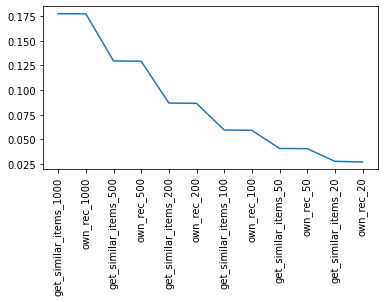

In [14]:
plt.figure(figsize=(6,3))
plt.plot([x[0] for x in Counter(result).most_common()], [x[1] for x in Counter(result).most_common()])
plt.xticks(rotation=90)
plt.show()

Метрика растёт с увеличением N. Попробую взять N=1000

# Генерация признаков

In [15]:
data_lvl_1 = pd.concat([data_train_lvl_1, data_val_lvl_1])
data_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


In [16]:
N = 1000
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# разворачиваем товары
df_items = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(df_items)
users_lvl_2.head(2)

data_train_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
data_train_lvl_2['target'] = 1  # тут только покупки 

# Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качестве нулей
data_train_lvl_2 = users_lvl_2.merge(data_train_lvl_2, on=['user_id', 'item_id'], how='left')

# чистим дубликаты
data_train_lvl_2 = data_train_lvl_2.drop_duplicates(subset=['user_id', 'item_id'])
data_train_lvl_2['target'].fillna(0, inplace= True)

data_train_lvl_2['target'].value_counts()

0.0    1891202
1.0      23798
Name: target, dtype: int64

In [17]:
users_test = pd.DataFrame(data_val_lvl_2['user_id'].unique()).rename(columns={0:'user_id'})
users_test['candidates'] = users_test['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

df_items = users_test.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

users_test = users_test.drop('candidates', axis=1).join(df_items)
users_test.head(2)

,user_id,item_id
0,338,999999
0,338,1029743


In [18]:
def feature_generation(data_lvl_1, data_train_lvl_2, user_features, item_features):

    # средний чек
    user_average_bill = data_lvl_1.groupby(["user_id", "basket_id"])[['price']].mean().\
                                        groupby('user_id')['price'].mean()
    user_average_bill.name = "user_average_bill"
    user_features = user_features.merge(user_average_bill, how = 'left', on = 'user_id')
    
    # среднее количество покупок в неделю/месяц
    data_lvl_1['month'] = data_lvl_1['day'].apply(lambda x: (x+30)//30)

    user_monthes_sum_purchase = data_lvl_1.groupby(["user_id"])["month"].nunique()
    user_sum_purchases = data_lvl_1.groupby(['user_id'])['basket_id'].nunique()
    user_purchases_freq_per_month = user_sum_purchases / user_monthes_sum_purchase
    user_purchases_freq_per_month.name = "user_purchases_freq_per_month"

    user_weeks_sum_purchase = data_lvl_1.groupby(["user_id"])["week_no"].nunique()
    user_purchases_freq_per_week = user_sum_purchases / user_weeks_sum_purchase
    user_purchases_freq_per_week.name = "user_purchases_freq_per_week"

    user_features = user_features.merge(user_purchases_freq_per_month, how = 'left', on = 'user_id')
    user_features = user_features.merge(user_purchases_freq_per_week, how = 'left', on = 'user_id')
    
    # item features
    
    # Среднее кол-во покупок item_id в неделю
    item_per_week = data_lvl_1.groupby('item_id')['quantity'].sum().rename('item_per_week') / data_lvl_1['week_no'].max()
    item_features = item_features.merge(item_per_week, how='left', on='item_id', suffixes=(False, False))

    # Средняя частота item в корзине
    item_freq_per_basket = data_lvl_1.groupby(['item_id']).agg('user_id').count().rename('item_freq_per_basket')/data_lvl_1.basket_id.nunique()
    item_features = item_features.merge(item_freq_per_basket, how='left', on='item_id', suffixes=(False, False))

    # цена
    item_price = data_lvl_1.groupby(['item_id']).agg({'quantity': 'sum', 'sales_value': 'sum'})
    item_price = item_price['sales_value'] / item_price['quantity']
    item_price.name = 'item_price'
    item_features = item_features.merge(item_price, how='left', on="item_id", suffixes=(False, False))

    # Среднее кол-во покупок 1 товара в категории в неделю
    data_categ = pd.merge(data_lvl_1, item_features, how='inner', on='item_id')
    categ_freq_ = data_categ.groupby(['department'])['quantity'].sum()
    categ_item_freq_ = data_categ.groupby(['department', 'item_id'])['quantity'].sum().reset_index()
    categ_freq = pd.merge(categ_item_freq_, categ_freq_, on='department')
    categ_freq['category_freq'] = categ_freq['quantity_y'] / data_lvl_1['week_no'].max() / categ_freq['quantity_x']
    categ_freq.set_index('item_id', inplace=True)
    category_freq = categ_freq['category_freq']
    item_features = item_features.merge(category_freq, how='left', on='item_id', suffixes=(False, False))
    
    # (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    categ_user_freq_ = data_categ.groupby(['user_id', 'department'])['quantity'].sum().reset_index()
    categ_user_freq_['category_freq'] = categ_user_freq_['quantity'] / data_lvl_1['week_no'].max()
    categ_user_freq = pd.merge(categ_user_freq_, categ_freq_, on='department')
    categ_user_freq['avg_weekly_freq'] = categ_user_freq['quantity_y'] / data_lvl_1['week_no'].max()
    categ_user_freq['freq_ratio_2'] = categ_user_freq['category_freq'] / categ_user_freq['avg_weekly_freq']
    user_dep_ratio_2 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_2'], axis=1)

    # (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    categ_user_freq['freq_ratio_3'] = categ_user_freq['category_freq'] - categ_user_freq['avg_weekly_freq']
    user_dep_ratio_3 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_3'], axis=1)

    data_train_lvl_2 = data_train_lvl_2.merge(user_features, on='user_id', how='left', suffixes=(False, False))
    
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                          agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg("user_id").count().rename('item_freq'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg("user_id").count().rename('user_freq'), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('sales_value').sum().rename('total_user_sales_value'), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('item_quantity_per_week')/data_train_lvl_1.week_no.nunique(),
                                              how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('quantity').sum().rename('user_quantity_per_week')/data_train_lvl_1.week_no.nunique(),
                                              how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('item_quantity_per_basket')/data_train_lvl_1.basket_id.nunique(), 
                                              how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('quantity').sum().rename('user_quantity_per_baskter')/data_train_lvl_1.basket_id.nunique(), 
                                              how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg("user_id").count().rename('item_freq_per_basket')/data_train_lvl_1.basket_id.nunique(),
                                              how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg("user_id").count().rename('user_freq_per_basket')/data_train_lvl_1.basket_id.nunique(),
                                              how='left',on="user_id")
    
    return data_train_lvl_2

In [19]:
data_train_lvl_2 = feature_generation(data_lvl_1, data_train_lvl_2, user_features, item_features)
data_test = feature_generation(data_lvl_1, data_val_lvl_2, user_features, item_features)

In [20]:
X_train = data_train_lvl_2.drop('target', axis=1)
y_train = data_train_lvl_2[['target']]
X_train.head(2)

,user_id,item_id,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,...,total_quantity_value,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket
0,2070,999999,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.161997,...,274916,251603,592,3006.56,3234.305882,8.694118,1.824321,0.004904,1.669617,0.003928
1,2070,1029743,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.161997,...,10275,8899,592,3006.56,120.882353,8.694118,0.068184,0.004904,0.059053,0.003928


In [21]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
cat_feats

['age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_purchases_freq_per_month',
 'user_purchases_freq_per_week',
 'total_item_sales_value',
 'total_quantity_value',
 'item_freq',
 'user_freq',
 'total_user_sales_value',
 'item_quantity_per_week',
 'user_quantity_per_week',
 'item_quantity_per_basket',
 'user_quantity_per_baskter',
 'item_freq_per_basket',
 'user_freq_per_basket']

In [22]:
%%time
lgb = LGBMClassifier(objective='binary',
                     n_jobs=-1,
                     max_depth=50,
                     n_estimators=500,
                     learning_rate=0.1,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

CPU times: total: 6min
Wall time: 37.2 s


In [23]:
X_test = data_test[cat_feats + ["user_id", 'item_id']]
X_test[cat_feats] = X_test[cat_feats].astype('category')
X_test.tail(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,user_purchases_freq_per_month,user_purchases_freq_per_week,...,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,user_id,item_id
115986,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,4.440243,3.578947,1.658537,...,331,1649.08,NaN,4.964706,NaN,0.002800,NaN,0.002196,1001,13217800
115987,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2,4.831673,5.650000,1.661765,...,827,3741.78,NaN,10.705882,NaN,0.006039,NaN,0.005488,1167,6410462
115988,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2,4.831673,5.650000,1.661765,...,827,3741.78,NaN,10.705882,NaN,0.006039,NaN,0.005488,1167,6430664


**Получение рекомендаций и оценка precision@5 на тренировочном датасете**

In [24]:
df_predict = data_train_lvl_2.copy()
df_predict['proba_item_purchase'] = train_preds[:,1]

In [25]:
result_eval_ranker = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']

In [26]:
result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

In [27]:
result_eval_ranker.apply(lambda row: precision_at_k(row["own_rec"], row["actual"], k=5), axis=1).mean()

0.104543080939947

In [28]:
def rerank(user_id):
    return df_predict[df_predict['user_id'] == user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [29]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker["user_id"].apply(lambda user_id: rerank(user_id))

In [30]:
result_eval_ranker.apply(lambda row: precision_at_k(row["reranked_own_rec"], row["actual"], k=5), axis=1).mean()

0.22078328981722958

In [31]:
result_eval_ranker.head(2)

,user_id,actual,own_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1029743, 1106523, 5569230, 916122, 10...","[1082185, 1029743, 1102067, 899624, 901062]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[999999, 1029743, 1106523, 5569230, 916122, 10...","[1082185, 5570882, 845208, 8357613, 1029743]"


**Получение рекомендаций для тестового датасета**

In [32]:
test_preds = lgb.predict_proba(X_test)

In [33]:
df_test_predict = data_test.copy()
df_test_predict['proba_item_purchase'] = test_preds[:,1]
df_test_predict.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,proba_item_purchase
0,338,41260573635,636,840173,1,1.99,369,0.0,112,92,...,NaN,206,876.31,NaN,2.847059,NaN,0.001606,NaN,0.001367,0.007796
1,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,...,NaN,206,876.31,NaN,2.847059,NaN,0.001606,NaN,0.001367,0.007796


In [34]:
result = df_test_predict.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

In [35]:
result['rec'] = result["user_id"].apply(lambda user_id: rerank(user_id))
result[['user_id','rec']].head(2)

,user_id,rec
0,1,"[1082185, 1029743, 1102067, 899624, 901062]"
1,6,"[1082185, 5570882, 845208, 8357613, 1029743]"


In [36]:
result[['user_id','rec']].to_csv('recommendations.csv')

Вывод: на тестовом датасете удалось получить precision_at_k равной 0.22 при k=5